<a href="https://colab.research.google.com/github/tai/colab-tests/blob/main/mnist_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST on Torch on Colab

In [1]:
!python -V

Python 3.6.9


In [2]:
!pip install torch torchvision scikit-learn

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

import torch
torch.__version__

'1.7.0+cu101'

In [18]:
# load data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255
y = [float(s) for s in y]

In [4]:
print(device)

cuda


In [5]:
torch.cuda.get_device_name()

'Tesla T4'

3


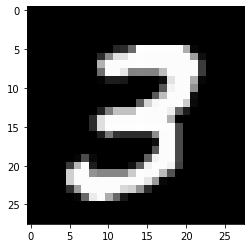

In [6]:
# show loaded image
plt.imshow(X[7].reshape(28,28), cmap=plt.cm.gray)
print("{:.0f}".format(y[7]))

In [7]:
# prepare dataloader

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

print(type(y_train[0]))

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

<class 'float'>


In [8]:
# build a model

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

model.to(device)
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [9]:
# setup lossfunc and optimizer

from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
# training

def train(epoch):
  model.train()

  for data, targets in loader_train:
    data, targets = data.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = model(data)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()

  print("epoch{}: done\n".format(epoch))

# run training loop 3 times
for epoch in range(3):
  train(epoch)

epoch0: done

epoch1: done

epoch2: done



In [14]:
# test/validate

def test():
  model.eval()
  correct = 0

  with torch.no_grad():
    for data, targets in loader_test:
      data, targets = data.cuda(), targets.cuda()

      outputs = model(data)

      _, predicted = torch.max(outputs.data, 1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()

  data_num = len(loader_test.dataset)
  print('\nresult: {}/{}({:.1f}%)\n'.format(correct, data_num, 100. * correct /data_num))

test()


result: 9665/10000(96.6%)



tensor([ 19.3600, -24.7088,  -8.9045, -11.0514,  -7.7953,  -6.4138,  -5.5216,
         -6.4003,  -9.0030,  -8.9424], device='cuda:0')


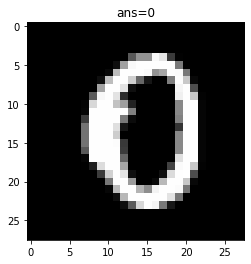

In [31]:
# try identifying a single image

def predict(model, img):
    model.eval()
    img_cuda = img.cuda()
    output = model(img_cuda)

    _, ans = torch.max(output.data, 0)
    print(output.data)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.set_title('ans={}'.format(ans))
    ax.imshow(img.numpy().reshape((28, 28)), cmap='gray')

predict(model, X_test[0])